In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Cargar dataset
file_path_hogar = '../../../../data/processed/datos_consumo/hogar_individual_bcn/casa_bcn_clean.csv'
df = pd.read_csv(file_path_hogar, parse_dates=["timestamp"])

# Preprocesamiento base
df["year"] = df["timestamp"].dt.year
df["month"] = df["timestamp"].dt.month
df["day"] = df["timestamp"].dt.day
df["weekday"] = df["timestamp"].dt.weekday
df["hour"] = df["timestamp"].dt.hour
df["is_weekend"] = (df["weekday"] >= 5).astype(int)

# Lista de festivos (Barcelona)
FESTIVOS = [
    "2017-01-06","2017-04-14","2017-04-17","2017-05-01","2017-06-05","2017-06-24",
    "2017-08-15","2017-09-11","2017-09-25","2017-10-12","2017-11-01","2017-12-06",
    "2017-12-08","2017-12-25","2017-12-26","2018-01-01","2018-01-06","2018-03-30",
    "2018-04-02","2018-05-01","2018-08-15","2018-09-11","2018-10-12","2018-11-01",
    "2018-12-06","2018-12-08","2018-12-25","2018-12-26","2019-01-01","2019-04-19",
    "2019-04-22","2019-05-01","2019-06-10","2019-06-24","2019-08-15","2019-09-11",
    "2019-09-24","2019-10-12","2019-11-01","2019-12-06","2019-12-25","2019-12-26",
    "2020-01-01","2020-01-06","2020-04-10","2020-04-13","2020-05-01","2020-06-01",
    "2020-06-24","2020-08-15","2020-09-11","2020-09-24","2020-10-12","2020-12-08",
    "2020-12-25","2020-12-26"
]
df["is_holiday"] = df["timestamp"].dt.strftime("%Y-%m-%d").isin(FESTIVOS).astype(int)

In [2]:
# Features de lags y rolling SIN fuga
df["lag_1h"] = df["consumo_kwh"].shift(1)
df["lag_24h"] = df["consumo_kwh"].shift(24)
df["rolling_3h"] = df["consumo_kwh"].shift(1).rolling(3).mean()
df["rolling_24h"] = df["consumo_kwh"].shift(1).rolling(24).mean()
df["delta"] = df["consumo_kwh"].diff().shift(1)

# Ciclicidad horaria
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

# Renombrar columnas para Prophet
df = df.rename(columns={"timestamp": "ds", "consumo_kwh": "y"})

# Eliminar nulos generados
df.dropna(inplace=True)

In [3]:
# Variables que usás como regresores
regresores = [
    'hour', 'weekday', 'is_weekend', 'is_holiday',
    'tmed', 'tmin', 'tmax', 'prec', 'velmedia', 'racha', 'sol', 'hrMedia', 'year',
    'lag_1h', 'lag_24h', 'rolling_3h', 'rolling_24h', 'delta',
    'hour_sin', 'hour_cos'
]

# Inicializar estructura de métricas y resultados
rmse_values, mae_values = [], []
predicciones_totales = pd.DataFrame()

# Rango de validación
start_val = pd.Timestamp('2020-01-01')
end_val = df['ds'].max().normalize()

In [4]:
# Definir umbral y pesos personalizados por hora pico
umbral_pico = 0.98
pesos_por_hora = {
    9: 0.25,
    10: 0.3,
    11: 0.2,
    14: 0.15,
}

# Validación secuencial diaria con reentrenamiento y ajuste de picos ponderado
for dia in pd.date_range(start=start_val, end=end_val, freq='D'):
    train = df[df['ds'] < dia]
    test = df[(df['ds'] >= dia) & (df['ds'] < dia + pd.Timedelta(days=1))]

    if test.empty or len(train) < 48:
        continue

    df_festivos = pd.DataFrame({
        "holiday": "festivo",
        "ds": pd.to_datetime(FESTIVOS),
        "lower_window": 0,
        "upper_window": 1
    })

    m = Prophet(
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=True,
        seasonality_mode='additive',
        holidays=df_festivos
    )

    for r in regresores:
        m.add_regressor(r)

    m.fit(train[["ds", "y"] + regresores])

    future = test[["ds"] + regresores].copy()
    forecast = m.predict(future)

    # Corrección manual de picos con pesos por hora
    forecast['hora'] = forecast['ds'].dt.hour
    forecast['ajuste_pico'] = forecast.apply(
        lambda row: pesos_por_hora.get(row['hora'], 0) if row['yhat'] < umbral_pico else 0,
        axis=1
    )
    forecast['yhat_ajustado'] = forecast['yhat'] + forecast['ajuste_pico']

    # Evaluar con la predicción ajustada
    y_real = test["y"].values
    y_pred = forecast["yhat_ajustado"].values

    rmse = np.sqrt(mean_squared_error(y_real, y_pred))
    mae = mean_absolute_error(y_real, y_pred)
    rmse_values.append(rmse)
    mae_values.append(mae)

    pred_dia = pd.DataFrame({
        "timestamp": test["ds"].values,
        "real": y_real,
        "predicho": y_pred
    })
    predicciones_totales = pd.concat([predicciones_totales, pred_dia])


18:45:50 - cmdstanpy - INFO - Chain [1] start processing
18:45:52 - cmdstanpy - INFO - Chain [1] done processing
18:45:54 - cmdstanpy - INFO - Chain [1] start processing
18:45:58 - cmdstanpy - INFO - Chain [1] done processing
18:46:00 - cmdstanpy - INFO - Chain [1] start processing
18:46:04 - cmdstanpy - INFO - Chain [1] done processing
18:46:05 - cmdstanpy - INFO - Chain [1] start processing
18:46:08 - cmdstanpy - INFO - Chain [1] done processing
18:46:09 - cmdstanpy - INFO - Chain [1] start processing
18:46:12 - cmdstanpy - INFO - Chain [1] done processing
18:46:13 - cmdstanpy - INFO - Chain [1] start processing
18:46:16 - cmdstanpy - INFO - Chain [1] done processing
18:46:18 - cmdstanpy - INFO - Chain [1] start processing
18:46:22 - cmdstanpy - INFO - Chain [1] done processing
18:46:24 - cmdstanpy - INFO - Chain [1] start processing
18:46:27 - cmdstanpy - INFO - Chain [1] done processing
18:46:28 - cmdstanpy - INFO - Chain [1] start processing
18:46:32 - cmdstanpy - INFO - Chain [1]

In [5]:
# Métricas globales
rmse_final = np.mean(rmse_values)
mae_final = np.mean(mae_values)
print(f"\nRMSE Final: {rmse_final:.2f}")
print(f"MAE Final: {mae_final:.2f}")


RMSE Final: 0.27
MAE Final: 0.19


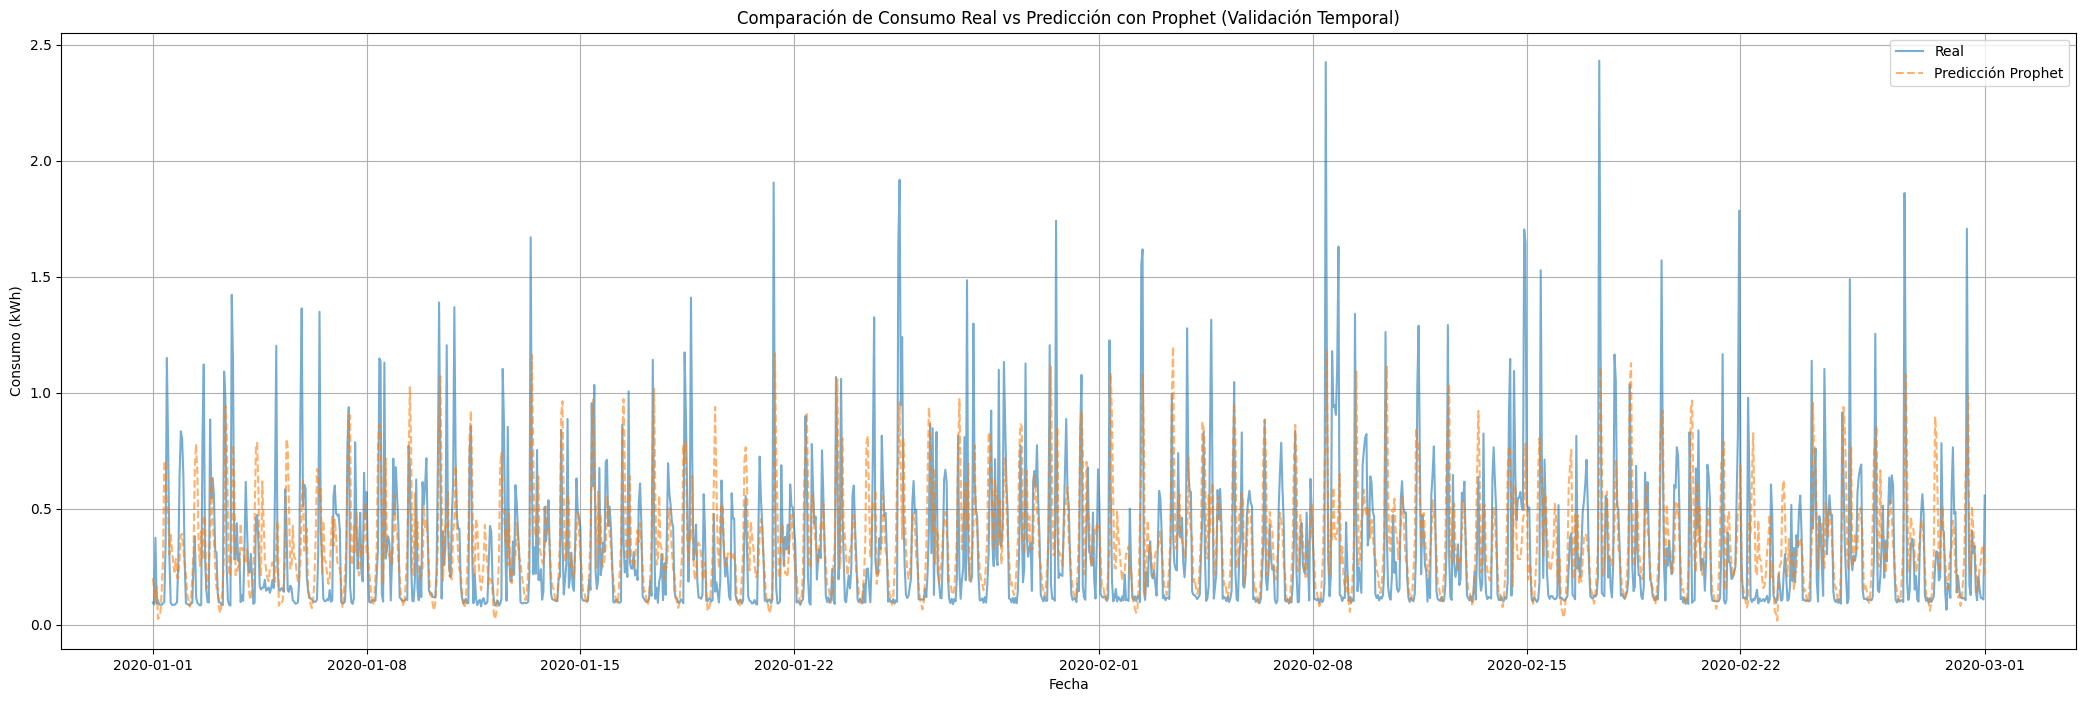

In [6]:
# Gráfico de resultados
plt.figure(figsize=(26, 8))
plt.plot(predicciones_totales['timestamp'], predicciones_totales['real'], label="Real", alpha=0.6)
plt.plot(predicciones_totales['timestamp'], predicciones_totales['predicho'], label="Predicción Prophet", linestyle="dashed", alpha=0.6)
plt.xlabel("Fecha")
plt.ylabel("Consumo (kWh)")
plt.title("Comparación de Consumo Real vs Predicción con Prophet (Validación Temporal)")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
import pandas as pd
import numpy as np

# Asegurar que 'timestamp' está en datetime
predicciones_totales['timestamp'] = pd.to_datetime(predicciones_totales['timestamp'])

# Ordenar por fecha por si acaso
predicciones_totales = predicciones_totales.sort_values('timestamp').reset_index(drop=True)

# Calcular el error absoluto
predicciones_totales['abs_error'] = np.abs(predicciones_totales['real'] - predicciones_totales['predicho'])

# Crear una ventana deslizante de 168 filas (7 días * 24 horas)
window_size = 168
rolling_error = predicciones_totales['abs_error'].rolling(window=window_size).mean()

# Encontrar el índice de la ventana con menor error medio
min_idx = rolling_error.idxmin()

# Extraer el mejor período
mejor_periodo = predicciones_totales.iloc[min_idx - window_size + 1:min_idx + 1].copy()

# Mostrar resumen
print(f"Periodo con menor error medio absoluto: {mejor_periodo['timestamp'].min()} a {mejor_periodo['timestamp'].max()}")
print(f"MAE en ese periodo: {mejor_periodo['abs_error'].mean():.4f}")


Periodo con menor error medio absoluto: 2020-02-01 10:00:00 a 2020-02-08 09:00:00
MAE en ese periodo: 0.1535


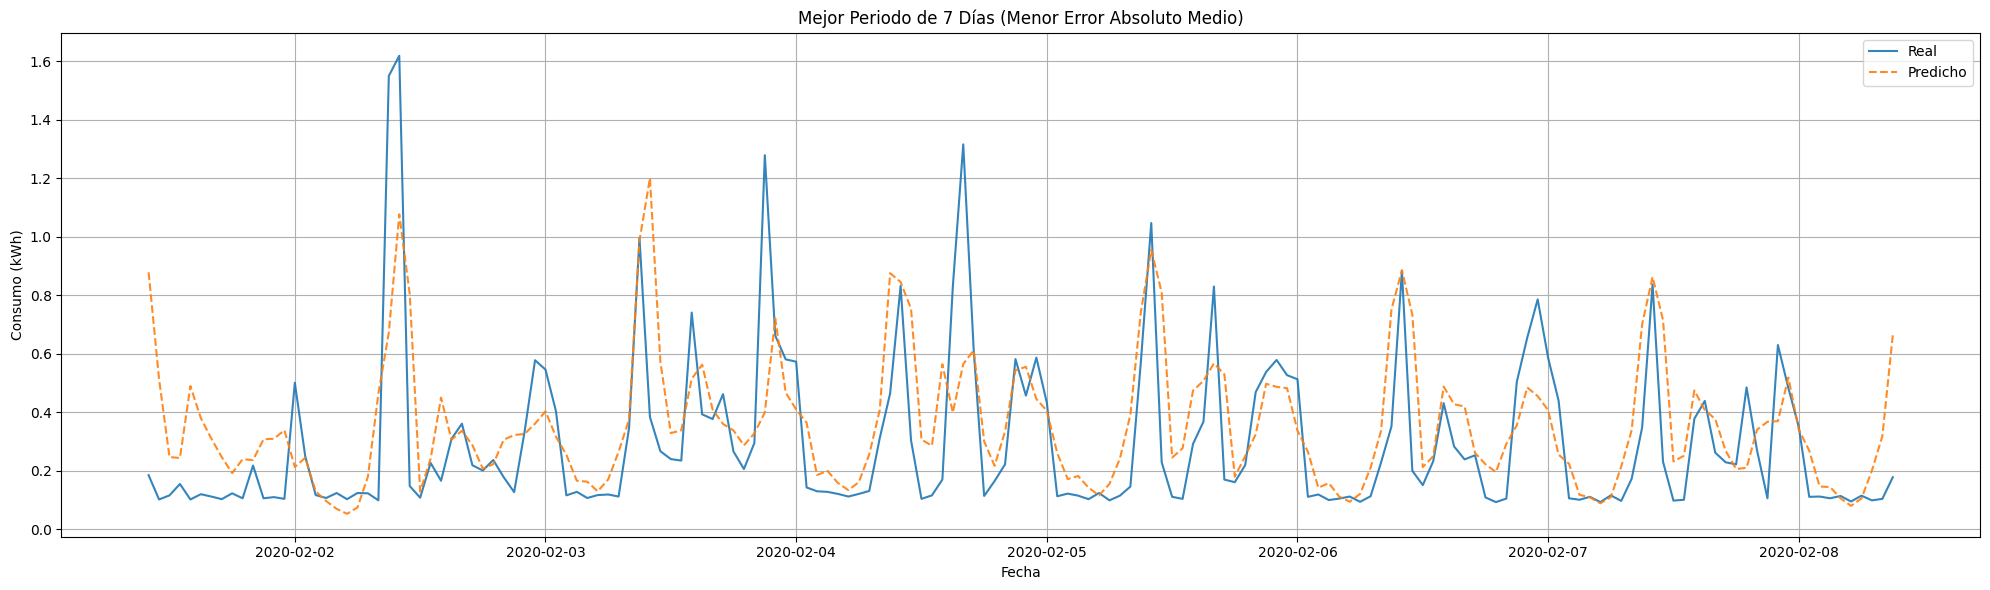

In [8]:
import matplotlib.pyplot as plt

# Graficar el mejor periodo
plt.figure(figsize=(20, 6))
plt.plot(mejor_periodo['timestamp'], mejor_periodo['real'], label='Real', alpha=0.9)
plt.plot(mejor_periodo['timestamp'], mejor_periodo['predicho'], label='Predicho', linestyle='--', alpha=0.9)

plt.title("Mejor Periodo de 7 Días (Menor Error Absoluto Medio)")
plt.xlabel("Fecha")
plt.ylabel("Consumo (kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
import mlflow
import dagshub
from prophet import Prophet
import pandas as pd
import numpy as np
import mlflow.pyfunc

# Inicializar conexión con DAGsHub
dagshub.init(repo_owner='auditoria.SGBA1', repo_name='Proyectos-SGBA1', mlflow=True)

class ProphetWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self, model):
        self.model = model
        self.umbral_pico = 0.98
        self.pesos_por_hora = {
            9: 0.25,
            10: 0.3,
            11: 0.2,
            14: 0.15,
            21: 0.1
        }

    def predict(self, context, model_input):
        forecast = self.model.predict(model_input.copy())

        # Extraer hora desde 'ds'
        forecast['hora'] = pd.to_datetime(forecast['ds']).dt.hour

        # Aplicar ajuste según hora y umbral
        forecast['ajuste_pico'] = forecast.apply(
            lambda row: self.pesos_por_hora.get(row['hora'], 0)
            if row['yhat'] < self.umbral_pico else 0,
            axis=1
        )

        forecast['yhat_ajustado'] = forecast['yhat'] + forecast['ajuste_pico']
        return forecast[["ds", "yhat_ajustado"]]

# ENTRENAMIENTO FINAL SOLO CON DATOS HASTA LA FECHA DE VALIDACIÓN
fecha_validacion = pd.Timestamp('2020-01-01')
df_entrenamiento = df[df['ds'] < fecha_validacion].copy()

# Crear dataframe de festivos
df_festivos = pd.DataFrame({
    "holiday": "festivo",
    "ds": pd.to_datetime(FESTIVOS),
    "lower_window": 0,
    "upper_window": 1
})

# Inicializar modelo Prophet
modelo_final = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='additive',
    holidays=df_festivos
)

# Agregar regresores
for r in regresores:
    modelo_final.add_regressor(r)

# Entrenar modelo
modelo_final.fit(df_entrenamiento[["ds", "y"] + regresores])

# Loggeo del modelo y métricas
model_name = "Prophet-Consumo-Hogar"
with mlflow.start_run(run_name=model_name):
    # Loggear modelo
    logged_model = mlflow.pyfunc.log_model(
        artifact_path=model_name,
        python_model=ProphetWrapper(modelo_final),
        conda_env=None
    )

    # Registrar como nueva versión en el Model Registry
    mlflow.register_model(model_uri=logged_model.model_uri, name=model_name)
    
    # Loggear métricas de validación
    mlflow.log_metric("RMSE_validacion", rmse_final)
    mlflow.log_metric("MAE_validacion", mae_final)

    # Tags
    mlflow.set_tag("framework", "Prophet")
    mlflow.set_tag("model_type", "forecasting")
    mlflow.set_tag("data_until", str(fecha_validacion.date()))
    mlflow.set_tag("regresores", ", ".join(regresores))


Accessing as anaigs

Initialized MLflow to track repo "auditoria.SGBA1/Proyectos-SGBA1"

Repository auditoria.SGBA1/Proyectos-SGBA1 initialized!

c:\Users\anaig\AppData\Local\Programs\Python\Python310\lib\site-packages\mlflow\pyfunc\utils\data_validation.py:134: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(
18:59:06 - cmdstanpy - INFO - Chain [1] start processing
18:59:08 - cmdstanpy - INFO - Chain [1] done processing
2025/05/04 18:59:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Prophet-Consumo-Hogar' already exists. Creating a new version of this model...
2025/05/04 18:59:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Prophet-Consumo-Hogar, version 3
Created version '3' of model 'Prophet-

🏃 View run Prophet-Consumo-Hogar at: https://dagshub.com/auditoria.SGBA1/Proyectos-SGBA1.mlflow/#/experiments/0/runs/1d1f303656b34982b3dce9fdaf6143eb
🧪 View experiment at: https://dagshub.com/auditoria.SGBA1/Proyectos-SGBA1.mlflow/#/experiments/0
